# Sharpe Style Analysis

an decomposition with added constraint that the coeddicients are all positive and add to 1.

Therefore, the coefficients of performing style analysis on the observed return of a manager can be interpreted as weights in a portfolio of building blocks which together, _mimic_ that return series. The exercise can reveal drifts in a manager's style as well as provide insight into what the manager is likely doing to obtain the returns.

# Performing
Quadriatic optimizer

find the weights that minimizes the square of the difference between the ovserved series and the returns of a benchmark portfolio that holds the explanatory building blocks in those same weights.

This is equivalent to minimizing the _tracking error_ between the two return series.

The code is similar to `minimize_vol`:

```python
def style_analysis(dependent_variable, explanatory_variables):
    """
    Returns the optimal weights that minimizes the Tracking error between a portfolio of the explanatory variables and the dependent variable
    """
    n = explanatory_variables.shape[1]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0,1.0),)*n # an N-tuple of 2-tuples
    # construct the constraints
    weights_sum_to_1 = {'type':'eq',
                        'fun': lambda weights：np.sum(weights) - 1
                       }
    solution = minimize(portfolio_tracking_error, 
                        init_guess,
                        args=(dependent_variable, explanatory_variables,), 
                        method = 'SLSQP', 
                        options = {'disp': False},
                        constraints = (weights_sum_to_1,),
                        bounds=bounds)
    weights = pd.Series(solution.x, index = explanatory_variables.columns)
    return weights
```

The objective function is a simple one-liner

```python
def portfolio_tracking_error(weights, ref_r, bb_r):
    """
    returns the tracking error between the reference returns and a portfolio of building block returns held with given weights
    """
    return tracking_error(ref_r, (weights*bb_r).sum(axis=1))
```

In [2]:
import numpy as np
import pandas as pd

import edhec_risk_kit_202 as erk

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ind = erk.get_ind_returns()['2000':]

Construct a manager that invests in 30% beer, 50% smoke and 20% in other things that have an average return of 0% and an annualized vol of 15%.

In [4]:
mgr_r = 0.3*ind['Beer'] + 0.5*ind['Smoke'] + 0.2*np.random.normal(scale=0.15/(12**.5), size = ind.shape[0])

In [8]:
ind.shape[0]

228

In [9]:
ind.shape[1]

30

In [13]:
np.random.normal(scale=0.15/(12**.5), size = 5)

array([ 0.0057566 , -0.00300614,  0.00682418, -0.00063538, -0.07611134])

In [14]:
np.random.normal(loc = 0, scale=0.15/(12**.5), size = 5)

array([-0.14527205, -0.02888362,  0.07856308, -0.02859511, -0.01029991])

Now assume we know nothing about the manager and all we abserve was the returns.

In [15]:
weights = erk.style_analysis(mgr_r, ind)*100

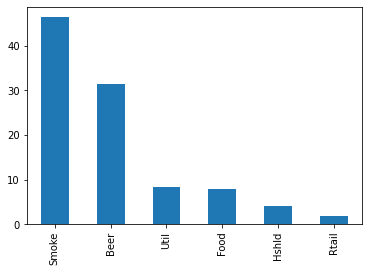

In [16]:
weights.sort_values(ascending=False).head(6).plot.bar()

when it works well, such as in this artificial example here, the results can be very accurate.

However, the negative coefficients are hard to intepret and in real-life data, those will be much larger. 

In [17]:
coeffs = erk.regress(mgr_r, ind).params*100
coeffs.sort_values().head()

Hlth    -4.312539
FabPr   -3.730467
Oil     -3.095421
Carry   -2.439300
Fin     -2.434667
dtype: float64

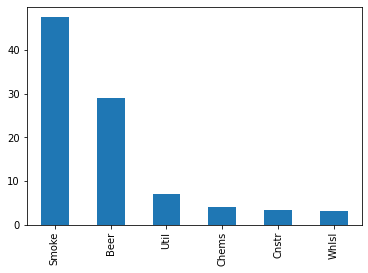

In [18]:
coeffs.sort_values(ascending=False).head(6).plot.bar()

## Style Drift: Time Varying Exposures using Style Anaylsis

One of the most common ways in which Sharpe Style Analysis can be used is to measure style drift. If you run the style analysis function over a rolling window of 1 to 5 years, you can extract changes in the style exposures of a manager.

## Warning: Potential Misuse of Style Analysis

Style Analysis works best when the explanatory indices are in fact a good specification of what is happening. For instance, it usually gives you very useful and revealing insight if you use a stock market index (such as SPY) and other broad indices, ETFs or mutual funds (such as a Value Fund, a Growth Fund, an International Fund, a Bond Fund etc).

Part of the skill in extracting meaningful results is to pick the right set of explanatory variables.

However, a part of the challenge with Style Analysis is that it will _always_ return a portfolio. Although it is possible to develop a figure of merit of fit quality similar to an $R^2$, it will still always give you an answer, however unreasonable it might be, and it's not always obvious how much one can rely on the result.

For instance, we can try and extract the major industries that Buffer invested in since 2000 as follows:

In [19]:
brka_m = pd.read_csv('brka_m.csv', index_col=0, parse_dates=True).to_period('M')

In [20]:
mgr_r_b = brka_m['2000':]['BRKA']
weights_b = erk.style_analysis(mgr_r_b, ind)
weights_b.sort_values(ascending=False).head(6).round(4)*100

Food     41.35
Fin      17.61
Meals    12.11
Other    11.03
Util      7.19
Clths     5.99
dtype: float64

look at the last decade(2009-2018):

In [22]:
brk2009 = brka_m['2009':]['BRKA']
ind2009 = ind['2009':]
erk.style_analysis(brk2009, ind2009).sort_values(ascending=False).head(6).round(4)*100

Other    43.64
Food     28.33
Hlth     22.72
Rtail     5.25
Meals     0.07
Games     0.00
dtype: float64

Probably should not believe this analysis.However, when the specification is in fact accurate (as we saw in the articially generated series) the results can be very revealing.